# MP2: lexical embedding
## Using skipgram noise contrastive estimation to learn real vector embeddings of words
## CS 440/ECE 448

All modern AI systems use real-valued vectors to represent words (or parts of words), in order to perform computations like next-word prediction, speech recognition, and natural language generation.  The vector representation of a word is typically called its [lexical embedding](https://en.wikipedia.org/wiki/Embedding).  Embeddings are learned from data, which raises the question: how are they learned?

One example of an effective, computationally efficient method for learning lexical embeddings is the skipgram noise contrastive estimation method proposed by [Mikolov, Sutskever, Chen, Corrado and Dean](https://proceedings.neurips.cc/paper/2013/hash/9aa42b31882ec039965f3c4923ce901b-Abstract.html) in 2014, and released as part of their patented [word2vec](https://code.google.com/archive/p/word2vec/) codebase. In this MP, you will implement a method to train lexical embeddings based on the algorithm described in their paper, with some modifications to make it easier to implement in an MP.  We will abbreviate the algorithm name as word2vec, as did the authors.

The code template is in the file [template.zip](template.zip), which you can download from this page.
All of the methods you need to write are in the file `embed.py`, and that is the only file you should upload to Gradescope.

In [1]:
%load_ext autoreload
%autoreload 1
%aimport embed

### 1. Initialize the embeddings

word2vec is a gradient descent method, which means that it can't learn the embeddings from scratch; instead, it takes some initial embeddings, and improves them.  In order to run word2vec, therefore, you have to initialize the embeddings.  That is done in the method `embeddings.initialize`.

Like most gradient descent methods, wordvec works badly if you initialize all of the parameters to the same value (e.g., zero), so we want to initialize the embeddings to something other than zero.  Most machine learning algorithms use random initialization, but in order to help with debugging, we will use a special type of initialization, described in the docstring:


In [236]:
help(embed.initialize)

Help on function initialize in module embed:

initialize(data, dim)
    Initialize embeddings for all distinct words in the input data.
    Most of the dimensions will be zero-mean unit-variance Gaussian random variables.
    In order to make debugging easier, however, we will assign special geometric values
    to the first two dimensions of the embedding:

    (1) Find out how many distinct words there are.
    (2) Choose that many locations uniformly spaced on a unit circle in the first two dimensions.
    (3) Put the words into those spots in the same order that they occur in the data.

    Thus if data[0] and data[1] are different words, you should have

    embedding[data[0]] = np.array([np.cos(0), np.sin(0), random, random, random, ...])
    embedding[data[1]] = np.array([np.cos(2*np.pi/N), np.sin(2*np.pi/N), random, random, random, ...])

    ... and so on, where N is the number of distinct words, and each random element is
    a Gaussian random variable with mean=0 and standar

We need some data.  For now, let's use the following dummy data.  We can start out with 4-dimensional embeddings.  That's smaller than we would normally use, but it will avoid wasting computation while we debug.

In [241]:
data='''
# # #
a b c d a b c d a b c d a b c d
# # #
e f g h e f g h e f g h e f g h
# # #
'''.split()
embedding = embed.initialize(data, 4)

If we plot just the first two dimensions of each embedding, they should lie on a circle.  If we plot the first three dimensions, we should see the randomness of the third dimension.

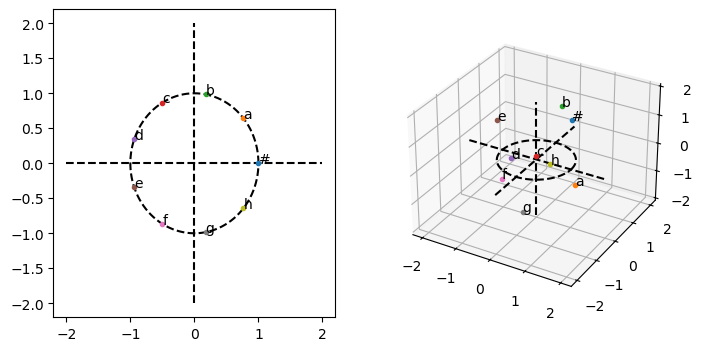

In [242]:
import matplotlib.pyplot as plt
import numpy as np
fig = plt.figure(figsize=(8,4))
ax0 = fig.add_subplot(1,2,1)
ax1 = fig.add_subplot(1,2,2,projection='3d')
ax1.set_zlim(-2,2)

# Plot the axes as dashed lines
theta = np.linspace(0,2*np.pi,1000)
ax0.plot([-2,2],[0,0],'k--',[0,0],[-2,2],'k--',np.cos(theta),np.sin(theta),'k--')
ax1.plot([-2,2],[0,0],[0,0],'k--')
ax1.plot([0,0],[-2,2],[0,0],'k--')
ax1.plot([0,0],[0,0],[-2,2],'k--')
ax1.plot(np.cos(theta),np.sin(theta),np.zeros(1000),'k--')

# Plot the vector value of each embedding
for w,v in embedding.items():
    ax0.plot(v[0],v[1], '.')
    ax0.text(v[0],v[1],w,None)
    ax1.plot(v[0],v[1],v[2], '.')
    ax1.text(v[0],v[1],v[2],w,None)

If you've done this correctly, you should now have nine embeddings (one for each distinct word), and they should be uniformly spaced around a unit circle in the first two dimensions, starting at $\theta=0$, and ending at $\theta=\frac{16\pi}{9}$, with random offsets into the third and fourth dimensions.  Note, as mentioned before, this initialization is not really necessary for good performance of the algorithm; we're just doing it to help with debugging.

## 2. Gradients of the Skipgram NCE Loss

The skipgram NCE loss for the $t^{\text{th}}$ word is:

$$\mathcal{L}_t=-\sum_{\begin{array}{c}c=-d:c\ne 0,\\0\le t+c<|\mathcal{D}|\end{array}}^d\left(\log\sigma(\mathbf{v}_{t}^T\mathbf{v}_{t+c})+\frac{1}{k}\sum_{i=1}^k\mathbb{E}_{w_i\sim P}\left[\log\left(1-\sigma(\mathbf{v}_t^T\mathbf{v}_i)\right)\right]\right)$$

Let's break that down.

* $\mathbf{v}_t$ is the vector embedding of the $t^{\text{th}}$ word, $w_t$.
* $\mathbf{v}_{t+c}$ is the embedding of one of its context words, $w_{t+c}$ ($|\mathcal{D}|$ is the length of the training dataset).
* We estimate the similarity between $\mathbf{v}_t$ and $\mathbf{v}_{t+c}$ by their dot product, $\mathbf{v}_t^T\mathbf{v}_{t+c}$.
* By passing the similarity score through a logistic sigmoid as $\sigma(\mathbf{v}_t^T\mathbf{v}_{t+c})$, we get a number between 0 and 1 that we can interpret as the probability that word $w_{t+c}$ occurs in the context of word $w_t$.  This is called the "skipgram probability."
* The term $\mathbb{E}_{w_i\sim P}\left[\log\left(1-\sigma(\mathbf{v}_t^T\mathbf{v}_i)\right)\right]$ is the expected value, over words $w_i$ drawn according to some probability distribution $P$, of the log probability that word $w_i$ does NOT occur in the context of $w_t$.  The formula suggests that we want the true value of this expectation, but in practice, we compute a very crude estimate: we just sample one word randomly from the distribution $P$, and then we compute $\log\left(1-\sigma(\mathbf{v}_t^T\mathbf{v}_i)\right)$ for the word that we sampled.
* The reasoning behind the loss: If $w_{t+c}$ is in the context of word $w_t$, we want to increase the neural net's estimate of the probability of this event.  If $w_i$ is chosen completely at random, we consider it to be random noise, so we try to increase the probability that $w_i$ and $w_t$ are NOT in context.  We treat these as independent events, so their probabilities are multiplied.  Maximizing the probability of these events is the same as minimizing the negative log probability.  



The context window ($d$) and the noise sample size ($k$) are called hyperparameters.  Hyperparameters are numbers that need to be chosen before you can begin gradient descent.  We will specify them as parameters of the function called `embed.gradient`:

In [243]:
help(embed.gradient)

Help on function gradient in module embed:

gradient(embedding, data, t, d, k)
    Calculate gradient of the skipgram NCE loss with respect to the embedding of data[t]

    @param:
    embedding - dict mapping from words (strings) to numpy arrays.
    data (list) - list of words in the input text, split on whitespace
    t (int) - data index of word with respect to which you want the gradient
    d (int) - choose context words between t-d and t-d, not including t
    k (int) - compare each context word to k words chosen uniformly at random from the data

    @return:
    g (numpy array) - loss gradients with respect to embedding of data[t]



Choose $d=4$ and a sufficiently large value of $k$, e.g., $k=15$.

In [244]:
g = [np.zeros(2)]*len(data)
for t in [3,4,5,6,22,23,24,25]:
    print('Computing gradient of',data[t])
    g[t] = embed.gradient(embedding, data, t, 4, 15)


Computing gradient of a
Computing gradient of b
Computing gradient of c
Computing gradient of d
Computing gradient of e
Computing gradient of f
Computing gradient of g
Computing gradient of h


Gradient descent will move in the direction of the NEGATIVE gradient, so let's plot the negative gradients, multiplied by some learning rate.  You should find that:

* Each word's negative gradient points toward the average of the words that appear in its context, and away from the average of all words.
* Moving in that direction will decrease the loss by making each word more similar to the words that appear in its context, and less similar to the average of all words.


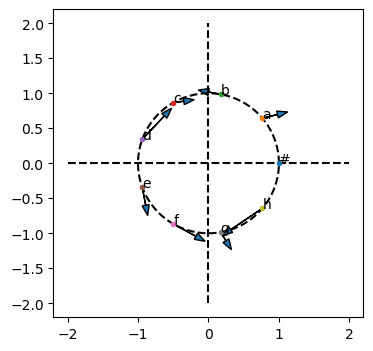

In [245]:
fig = plt.figure(figsize=(4,4))
ax0 = fig.add_subplot(1,1,1)

# Plot the axes as dashed lines
theta = np.linspace(0,2*np.pi,1000)
ax0.plot([-2,2],[0,0],'k--',[0,0],[-2,2],'k--',np.cos(theta),np.sin(theta),'k--')

# Plot the vector value of each embedding
for w,v in embedding.items():
    ax0.plot(v[0],v[1], '.')
    ax0.text(v[0],v[1],w,None)
    
# Plot the negative gradients as arrows pointing away from their current embeddings
lr = 0.2
for t in [3,4,5,6,22,23,24,25]:
    v = embedding[data[t]]
    ax0.arrow(v[0],v[1],-lr*g[t][0],-lr*g[t][1],head_width=0.1)


## 3. Stochastic Gradient Descent

Stochastic gradient descent repeats the following steps:

1. Choose a word uniformly at random from the data.
2. Compute its gradient.
3. Move the embedding in the direction of the negative gradient, scaled by the learning rate.



In [246]:
help(embed.sgd)

Help on function sgd in module embed:

sgd(embedding, data, learning_rate, num_iters, d, k)
    Perform num_iters steps of stochastic gradient descent.

    @param:
    embedding - dict mapping from words (strings) to numpy arrays.
    data (list) - list of words in the input text, split on whitespace
    learning_rate (scalar) - scale the negative gradient by this amount at each step
    num_iters (int) - the number of iterations to perform
    d (int) - context width hyperparameter for gradient computation
    k (int) - noise sample size hyperparameter for gradient computation

    @return:
    embedding - the updated embeddings



After running a few thousand iterations of SGD, you should find that the set {'a','b','c','d'} have all clustered together, as has the set {'e','f','g','h'}.  The '#' symbol occurs equally often in either context, so it shows up in the middle of the vector space:

In [247]:
embedding = embed.sgd(embedding, data, 0.01, 2000, 4, 15)

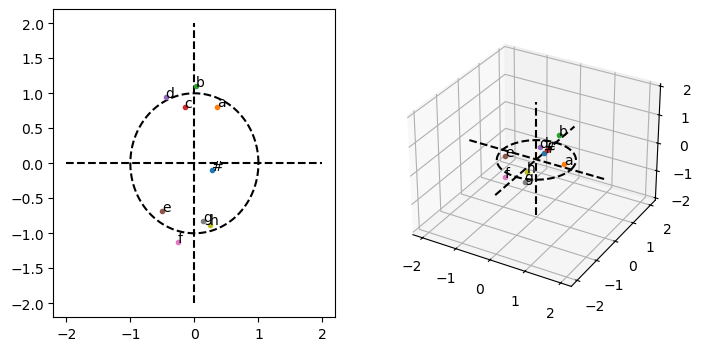

In [248]:
import matplotlib.pyplot as plt
import numpy as np
fig = plt.figure(figsize=(8,4))
ax0 = fig.add_subplot(1,2,1)
ax1 = fig.add_subplot(1,2,2,projection='3d')

# Plot the axes as dashed lines
theta = np.linspace(0,2*np.pi,1000)
ax0.plot([-2,2],[0,0],'k--',[0,0],[-2,2],'k--',np.cos(theta),np.sin(theta),'k--')
ax1.plot([-2,2],[0,0],[0,0],'k--')
ax1.plot([0,0],[-2,2],[0,0],'k--')
ax1.plot([0,0],[0,0],[-2,2],'k--')
ax1.plot(np.cos(theta),np.sin(theta),np.zeros(1000),'k--')

# Plot the vector value of each embedding
for w,v in embedding.items():
    ax0.plot(v[0],v[1], '.')
    ax0.text(v[0],v[1],w,None)
    ax1.plot(v[0],v[1],v[2], '.')
    ax1.text(v[0],v[1],v[2],w,None)

If your training results in embeddings that diverge to very large values, it probably means that you have an error in your gradient computation.

Once you're pretty sure that your code is behaving correctly, try submitting it to Gradescope.  The autograder will compare your performance to thresholds that should be satisfied no matter what random choices are made by your code, and give you error messages if those thresholds aren't met.

You might find it interesting to test your code with real data, and/or to experiment with one of the lexical embedding demos online, e.g., https://remykarem.github.io/word2vec-demo/.